## If you have not yet run the preprocessing notebook (Tiff_To_NumPy.ipynb), please do that first!

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K

We won't use all of these loss metrics at first, but let's go ahead and define them in case we decide to change our loss function later.

In [21]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

Let's start by loading the files we preprocessed in the last notebook

In [47]:
data = np.load(r'.\data_train.npy')
labels = np.load(r'.\label_train.npy')
data_test = np.load(r'.\data_test.npy')
labels_test = np.load(r'.\label_test.npy')

We need to tell Tensorflow the size of our input image. This will depend on how we resized the images during preprocessing.

In [48]:
nx = 512
ny = 512

In [49]:
#data = data[:,:,:,:]

The normalized difference vegetation index is a common measurement used in remote sensing. Let's add it as a fifth channel to see if it improves results.

In [36]:
ndvi = np.expand_dims((data[:,:,:,0]-data[:,:,:,1])/(data[:,:,:,0]+data[:,:,:,1]), axis=-1)
data = np.append(data, ndvi, axis=-1)

In [50]:
ndvi_test = np.expand_dims((data_test[:,:,:,0]-data_test[:,:,:,1])/(data_test[:,:,:,0]+data_test[:,:,:,1]), axis=-1)
data_test = np.append(data_test, ndvi_test, axis=-1)

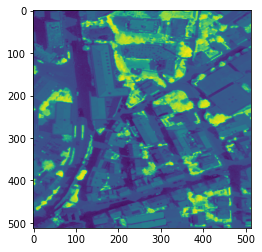

In [37]:
sample_ndvi_image = data[0,:,:,-1]
plt.imshow(sample_ndvi_image)

To improve learning, let's normalize by subtracting the mean and dividing by the standard deviation.

In [38]:
# Standardization across all samples (band specific)
data_scaled = np.zeros(np.shape(data))
data_normalized = np.zeros((np.shape(data)))
for i in range(np.shape(data)[-1]):
    data_mean = np.mean(data[:,:,:,i])
    data_std = np.std(data[:,:,:,i])
    data_scaled[:,:,:,i] = (data[:,:,:,i]-data_mean)/data_std

In [51]:
# Standardization across all samples (band specific)
data_test_scaled = np.zeros(np.shape(data_test))
data_test_normalized = np.zeros((np.shape(data_test)))
for i in range(np.shape(data_test)[-1]):
    data_test_mean = np.mean(data_test[:,:,:,i])
    data_test_std = np.std(data_test[:,:,:,i])
    data_test_scaled[:,:,:,i] = (data_test[:,:,:,i]-data_test_mean)/data_test_std

In [52]:
x = data_scaled
y = labels[:,:,:,:-1] # exclude clutter
x_test = data_test_scaled
y_test = labels_test[:,:,:,:-1]

Now that we have our data and labels as we want them, we can split our dataset into a portion for training and a portion for validation.

In [40]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.10, shuffle=True, random_state=1234)

We can further augment our training data by introducing data augmentations where we flip the images in various ways, add noise, etc. For right now, I'll leave this commented out, just to establish a baseline performance.

In [11]:
# Data augmentation on just the training data
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=1) for x in x_train]
Vy = [np.flip(x, axis=1) for x in y_train]

# Horizontal Image
Hx = [np.flip(x, axis=2) for x in x_train]
Hy = [np.flip(x, axis=2) for x in y_train]

# Horizontal Vertical Image
HVx = [np.flip(x, axis=2) for x in Vx]
HVy = [np.flip(x, axis=2) for x in Vy]

# Appending the augmented image and mask to the main dataset.
x_train = np.append(x_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

x_train = np.append(x_train, Hx, axis=0)
y_train = np.append(y_train, Hy, axis=0)

x_train = np.append(x_train, HVx, axis=0)
y_train = np.append(y_train, HVy, axis=0)

We now define the neural network. The basic building block is a convolutional block with two 2D convolutional operators, along with the potential for batch normalization, and finally an activation function. I have it defined as ReLU for right now, but this can be easily altered.

In [41]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, l2_lambda=0, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizers.l2(l2_lambda))(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same", kernel_regularizer=regularizers.l2(l2_lambda))(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [43]:
def get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(5, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

We're almost ready to start training. Let's create a model object, compile it, and summarize it so we can make sure the layers were built the way we wanted them to be built by Keras. We'll also define our optimizer, Adam, and pick a loss function and tracking metrics.

In [44]:
input_img = Input((nx, ny, 5), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", f1])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 5) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 32) 1472        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512, 512, 32) 128         conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 512, 512, 32) 0           batch_normalization_36[0][0]     
_______________________________________________________________________________________

Callbacks instruct Tensorflow how to behave during training. We can institute early stopping, reductions in training loss, and so on.

In [45]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-test-10.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

Now let's train our model!

In [46]:
results = model.fit(x_train, y_train, batch_size=1, epochs=100, callbacks=callbacks,
                   validation_data=(x_val, y_val))

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.3617 - categorical_accuracy: 0.5053 - f1: 0.4614WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0329s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 1.44682, saving model to model-test-10.h5
14/14 [==============================] - 3s 181ms/step - loss: 1.3617 - categorical_accuracy: 0.5053 - f1: 0.4614 - val_loss: 1.4468 - val_categorical_accuracy: 0.6401 - val_f1: 0.5119
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.1078 - categorical_accuracy: 0.7288 - f1: 0.5899
Epoch 00002: val_loss did not improve from 1.44682
14/14 [==============================] - 2s 133ms/step - loss: 1.1078 - categorical_accuracy: 0.7288 - f1: 0.5899 - val_loss: 2.0164 - val_categorical_accuracy: 0.6871 - val_f1: 0.5339
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.0086 - cat

14/14 [==============================] - 2s 145ms/step - loss: 0.4971 - categorical_accuracy: 0.8322 - f1: 0.8200 - val_loss: 0.4245 - val_categorical_accuracy: 0.8526 - val_f1: 0.8432
Epoch 22/100
14/14 [==============================] - ETA: 0s - loss: 0.4935 - categorical_accuracy: 0.8332 - f1: 0.8215
Epoch 00022: val_loss did not improve from 0.42450
14/14 [==============================] - 2s 142ms/step - loss: 0.4935 - categorical_accuracy: 0.8332 - f1: 0.8215 - val_loss: 0.4318 - val_categorical_accuracy: 0.8497 - val_f1: 0.8386
Epoch 23/100
14/14 [==============================] - ETA: 0s - loss: 0.4917 - categorical_accuracy: 0.8335 - f1: 0.8220
Epoch 00023: val_loss did not improve from 0.42450
14/14 [==============================] - 2s 140ms/step - loss: 0.4917 - categorical_accuracy: 0.8335 - f1: 0.8220 - val_loss: 0.4407 - val_categorical_accuracy: 0.8431 - val_f1: 0.8334
Epoch 24/100
14/14 [==============================] - ETA: 0s - loss: 0.4898 - categorical_accuracy: 

Finally, let's plot our results to see how our training and predictions look.

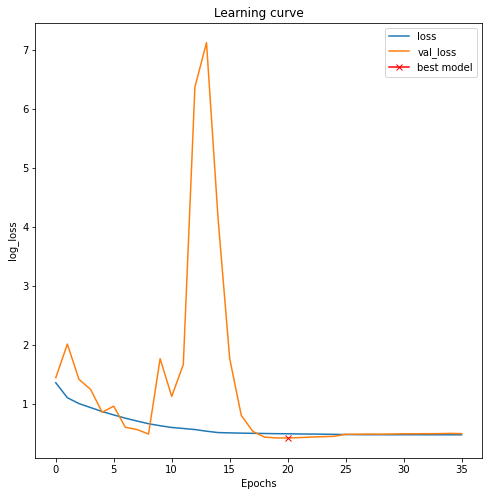

In [53]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [54]:
# Load best model
model.load_weights('model-test-10.h5')

In [55]:
# Evaluate on test set
model.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.4763 - categorical_accuracy: 0.8322 - f1: 0.8202


[0.47629794478416443, 0.8322159051895142, 0.8202035427093506]

In [56]:
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(x_test, verbose=1)

1/1 [==============================] - 1s 623ms/step


In [57]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [58]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 10))
    r_band = (X[ix,:,:,0]-np.min(X[ix,:,:,0]))/(np.max(X[ix,:,:,0])-np.min(X[ix,:,:,0]))
    g_band = (X[ix,:,:,1]-np.min(X[ix,:,:,1]))/(np.max(X[ix,:,:,1])-np.min(X[ix,:,:,1]))
    b_band = (X[ix,:,:,2]-np.min(X[ix,:,:,2]))/(np.max(X[ix,:,:,2])-np.min(X[ix,:,:,2]))
    RGB = np.stack((r_band, g_band, b_band), axis=-1)
    print(np.shape(RGB))
    im0 = ax[0,0].imshow(RGB)
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im0, ax=ax[0,0], fraction=0.046, pad=0.04)
    ax[0,0].set_title('Remote Sensing Image')

    im1 = ax[0,1].imshow(y[ix,:,:,0].squeeze())
    ax[0,1].set_title('Impervious Surfaces')
    fig.colorbar(im1, ax=ax[0,1], fraction=0.046, pad=0.04)
    
    im2 = ax[1,0].imshow(preds[ix,:,:,0].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im2, ax=ax[1,0], fraction=0.046, pad=0.04)
    ax[1,0].set_title('Impervious Surfaces Predicted')
    
    im3 = ax[1,1].imshow(binary_preds[ix,:,:,0].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im3, ax=ax[1,1], fraction=0.046, pad=0.04)
    ax[1,1].set_title('Impervious Surfaces Predicted (Binary)')
    fig.tight_layout();

In [59]:
def plot_sample_all(X, y, preds, binary_preds, ix=None, filename='Sample.png'):
    import matplotlib

    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(20, 50))
    r_band = (X[ix,:,:,0]-np.min(X[ix,:,:,0]))/(np.max(X[ix,:,:,0])-np.min(X[ix,:,:,0]))
    g_band = (X[ix,:,:,1]-np.min(X[ix,:,:,1]))/(np.max(X[ix,:,:,1])-np.min(X[ix,:,:,1]))
    b_band = (X[ix,:,:,2]-np.min(X[ix,:,:,2]))/(np.max(X[ix,:,:,2])-np.min(X[ix,:,:,2]))
    RGB = np.stack((r_band, g_band, b_band), axis=-1)

    im0 = ax[0,0].imshow(RGB)
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])

    ax[0,0].set_title('Remote Sensing Image', fontsize=30)
    
        
    im1 = ax[0,1].imshow(X[ix,:,:,4].squeeze(), cmap='gray')

    ax[0,1].set_title('NDVI', fontsize=30)
    
    im2 = ax[1,0].imshow(X[ix,:,:,3].squeeze(), cmap='gray')

    ax[1,0].set_title('Filtered DSM', fontsize=30)
    
    total_mask = np.zeros((256, 256, 3))
    for i in range(256):
        for j in range(256):
            # impervious surface
            if(y[ix,i,j,0]==1):
                total_mask[i,j,0]=1
                total_mask[i,j,1]=1
                total_mask[i,j,2]=1
            # building
            elif(y[ix,i,j,1]==1):
                total_mask[i,j,0]=0
                total_mask[i,j,1]=0
                total_mask[i,j,2]=1
            # low vegetation
            elif(y[ix,i,j,2]==1):
                total_mask[i,j,0]=0
                total_mask[i,j,1]=1
                total_mask[i,j,2]=1
            # tree
            elif(y[ix,i,j,3]==1):
                total_mask[i,j,0]=0
                total_mask[i,j,1]=1
                total_mask[i,j,2]=0
            # car
            elif(y[ix,i,j,4]==1):
                total_mask[i,j,0]=1
                total_mask[i,j,1]=0
                total_mask[i,j,2]=0

                
    im3 = ax[1,1].imshow(total_mask)
    ax[1,1].set_title('Image Mask', fontsize=30)
    
    im4 = ax[2,0].imshow(binary_preds[ix,:,:,0].squeeze(), vmin=0, vmax=1)

    ax[2,0].set_title('Impervious Surface Predicted (Binary)', fontsize=30)
    
    im5 = ax[2,1].imshow(binary_preds[ix,:,:,1].squeeze(), vmin=0, vmax=1)

    ax[2,1].set_title('Building Predicted (Binary)', fontsize=30)
    
    im6 = ax[3,0].imshow(binary_preds[ix,:,:,2].squeeze(), vmin=0, vmax=1)

    ax[3,0].set_title('Low Vegetation Predicted (Binary)', fontsize=30)
    
    im7 = ax[3,1].imshow(binary_preds[ix,:,:,3].squeeze(), vmin=0, vmax=1)

    ax[3,1].set_title('Trees Predicted (Binary)', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    im8 = ax[4,0].imshow(binary_preds[ix,:,:,4].squeeze(), vmin=0, vmax=1)

    ax[4,0].set_title('Cars Predicted (Binary)', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    total_preds = np.zeros((256,256,3))
    for i in range(256):
        for j in range(256):
            # impervious surface
            if(np.max(preds[ix,i,j])==preds[ix,i,j,0]):
                total_preds[i,j,0]=1
                total_preds[i,j,1]=1
                total_preds[i,j,2]=1
            # building
            elif(np.max(preds[ix,i,j])==preds[ix,i,j,1]):
                total_preds[i,j,0]=0
                total_preds[i,j,1]=0
                total_preds[i,j,2]=1
            # low vegetation
            elif(np.max(preds[ix,i,j])==preds[ix,i,j,2]):
                total_preds[i,j,0]=0
                total_preds[i,j,1]=1
                total_preds[i,j,2]=1
            # tree
            elif(np.max(preds[ix,i,j])==preds[ix,i,j,3]):
                total_preds[i,j,0]=0
                total_preds[i,j,1]=1
                total_preds[i,j,2]=0
            # car
            elif(np.max(preds[ix,i,j])==preds[ix,i,j,4]):
                total_preds[i,j,0]=1
                total_preds[i,j,1]=0
                total_preds[i,j,2]=0
    im9 = ax[4,1].imshow(total_preds)

    ax[4,1].set_title('All Maximum Class Predictions', fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=22)
    fig.tight_layout();
    plt.savefig(filename)

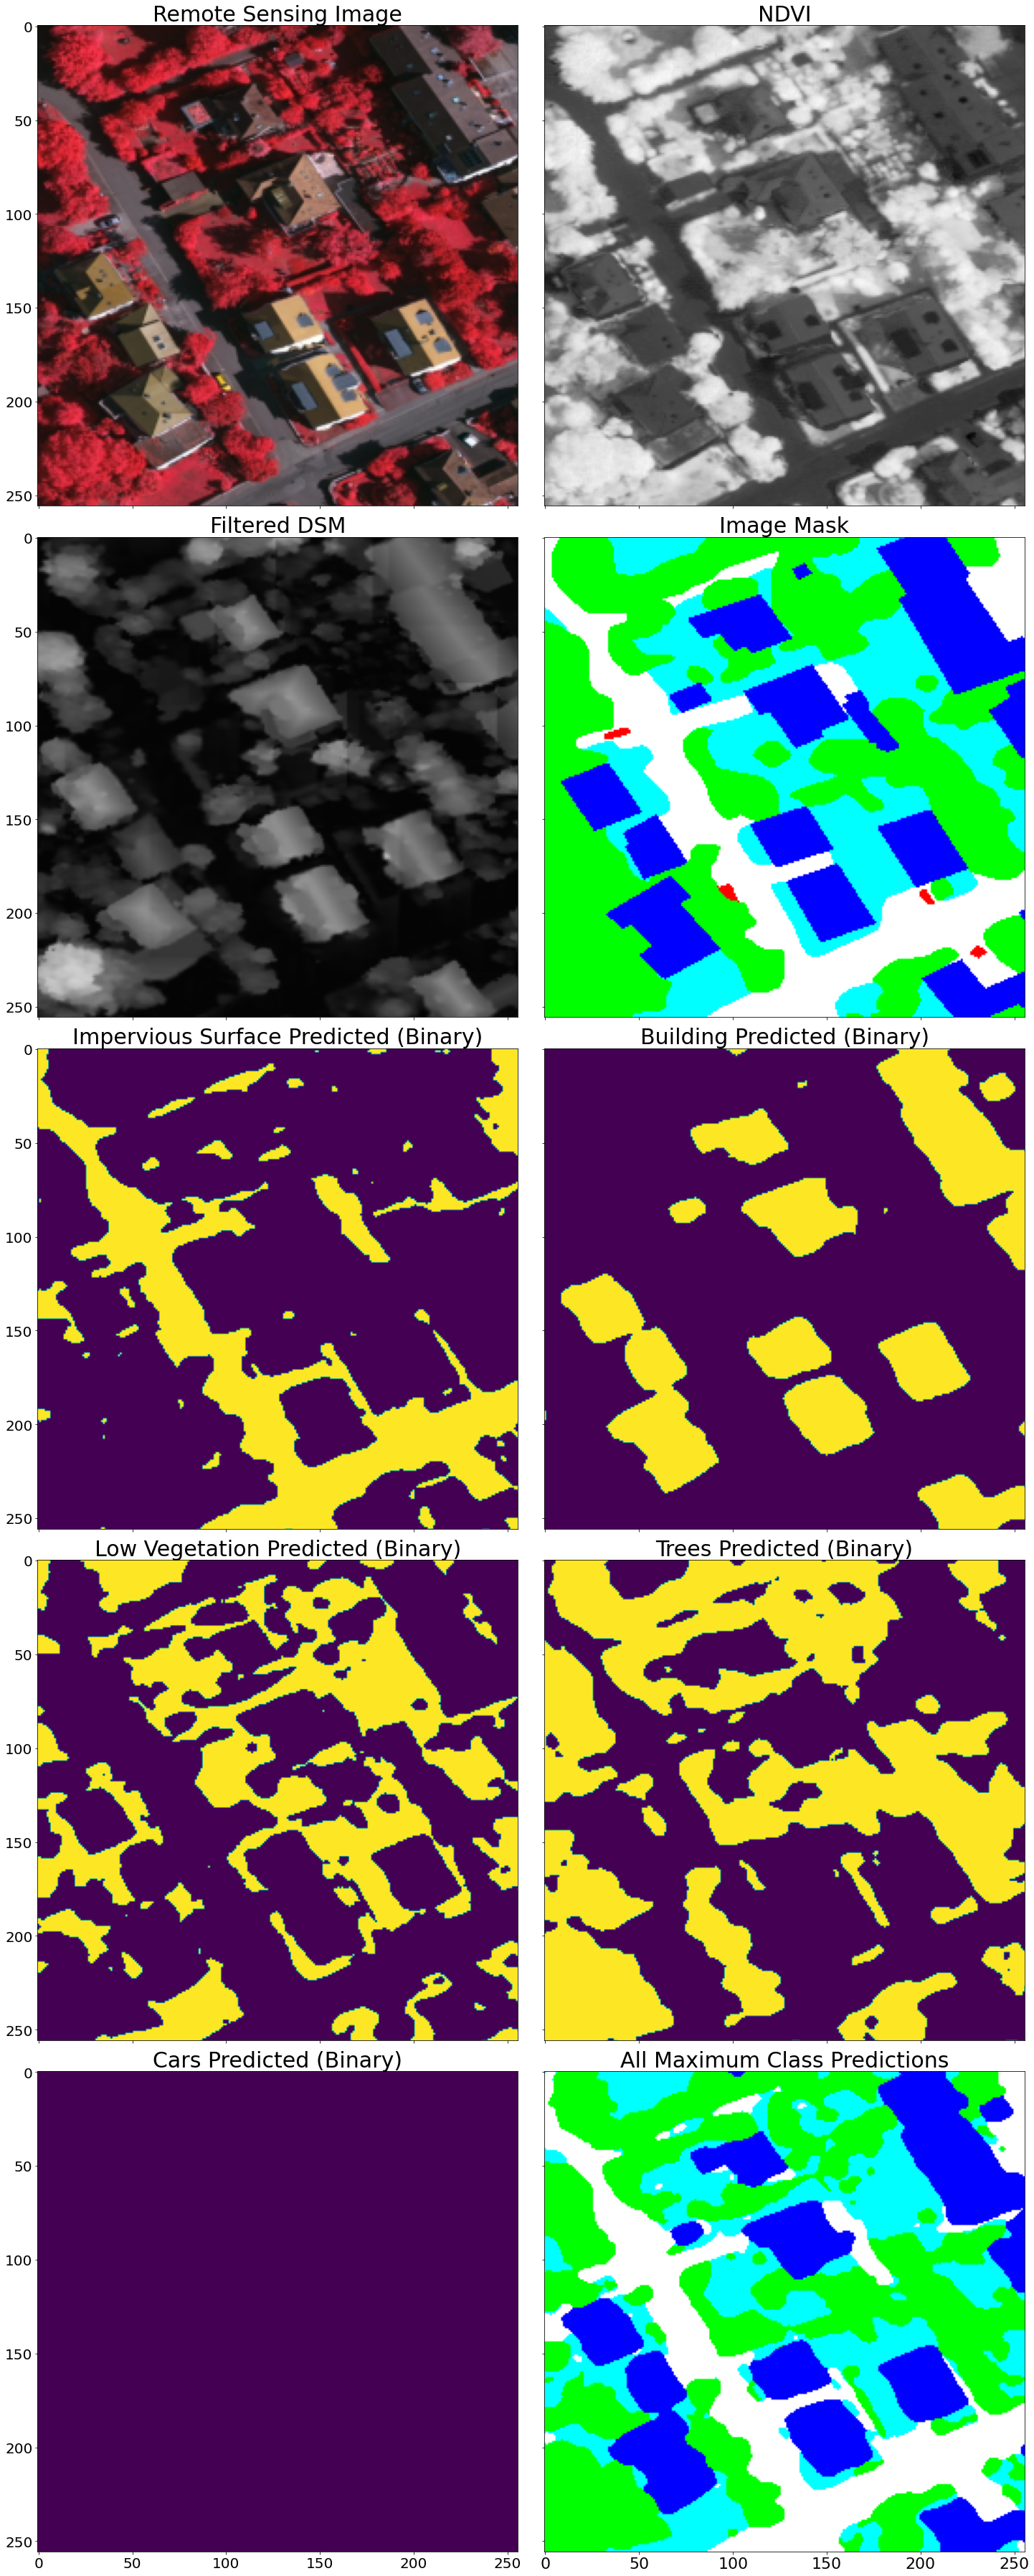

In [60]:
# Check if test data looks all right
plot_sample_all(x_test, y_test, preds_test, preds_test_t, ix=2, filename='test.png')

(512, 512, 3)


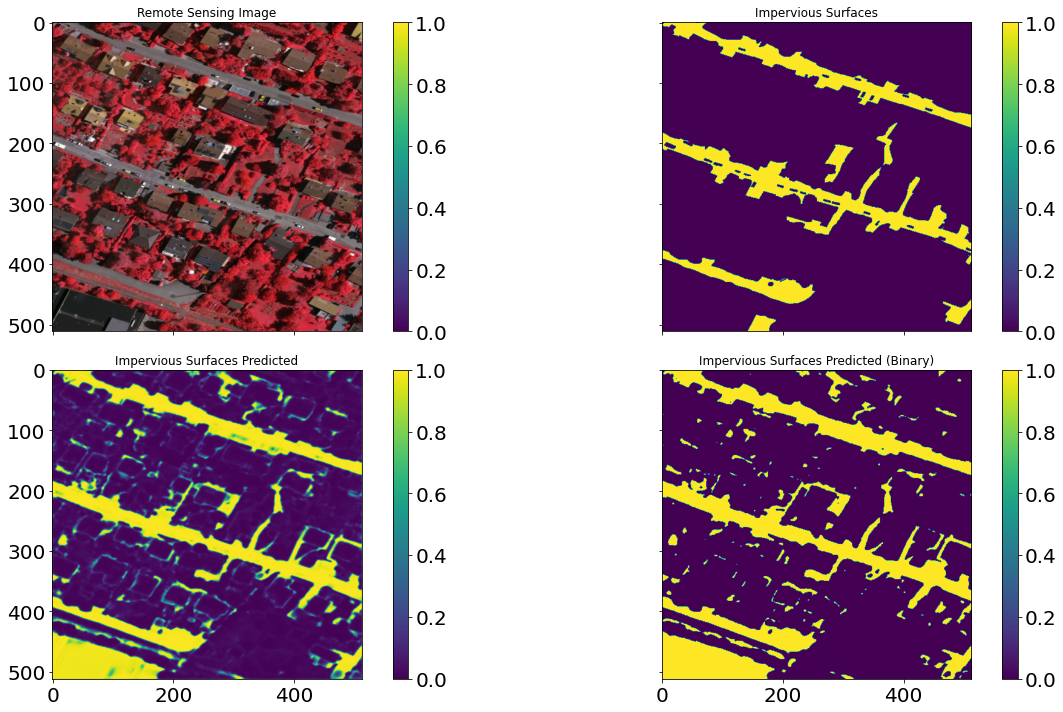

In [61]:
# Check if test data looks all right
plot_sample(x_test, y_test, preds_test, preds_test_t, ix=1)

And finally, just for good measure, let's calculate some receiver operator characteristics on either the total dataset, or the validation set.

In [ ]:
x_total = np.concatenate((x_train, x_val, x_test), axis=0)
y_total = np.concatenate((y_train, y_val, y_test), axis=0)
pred_total = np.concatenate((preds_train_t, preds_val_t), axis=0)

In [ ]:
print(np.shape(pred_total))
print(np.shape(y_total))

In [ ]:
c_matrix = confusion_matrix(y_total.ravel(), pred_total.ravel())

In [ ]:
def print_roc_metrics(y_real, y_predict):

    c_matrix = confusion_matrix(y_real.ravel(), y_predict.ravel())
    f1 = f1_score(y_real.ravel(), y_predict.ravel())
    recall = recall_score(y_real.ravel(), y_predict.ravel())
    precision = precision_score(y_real.ravel(), y_predict.ravel())
    print("Confusion matrix:")
    print(c_matrix)
    print("F1 score: {:.4f}".format(f1))
    print("Recall score: {:.4f}".format(recall))
    print("Precision score: {:.4f}".format(precision))

In [ ]:
print_roc_metrics(y_val, preds_val_t)